In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np 
import pandas as pd
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

# Data preparation

In [3]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset1/"

## SC data

#### Data reading

Single-cell preprocessed data of ‘Sample 21’ in MouseGastrulationData within the R/Bioconductor data package `MouseGastrulationData`, containing: normalized counts, cell metadata including cell type annotation.

In [41]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data_no_pp.h5ad")
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4651 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'X_name'

#### Counts inspection

In [5]:
print("Count format: ", adata_sc.uns['X_name'])
adata_sc.obs.head()

Count format:  counts


,cell,barcode,sample,pool,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,cluster.theiler,stripped,celltype,colour
cell_52466,cell_52466,AAACATACACGGAG,21,17,mixed_gastrulation,2,TS9-10,0.031554,False,14,2,5,5,False,Blood progenitors 2,c9a997
cell_52467,cell_52467,AAACATACCCAACA,21,17,mixed_gastrulation,2,TS9-10,0.136242,False,3,6,12,12,False,ExE ectoderm,989898
cell_52468,cell_52468,AAACATACTTGCGA,21,17,mixed_gastrulation,2,TS9-10,0.746898,False,2,3,3,3,False,Epiblast,635547
cell_52469,cell_52469,AAACATTGATCGGT,21,17,mixed_gastrulation,2,TS9-10,0.270453,False,1,3,1,1,False,Rostral neurectoderm,65A83E
cell_52470,cell_52470,AAACATTGCTTATC,21,17,mixed_gastrulation,2,TS9-10,0.222604,False,19,1,5,5,False,Haematoendothelial progenitors,FBBE92


In [6]:
# 1. Inspect basic stats
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # if sparse

pd.Series(X.ravel()).describe()


count    1.369813e+08
mean     6.002010e-01
std      4.958244e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.390000e+02
dtype: float64

In [7]:
# 2. Check if all values are integers
is_integer = np.allclose(X, np.round(X))
print("All integer values:", is_integer)


All integer values: True


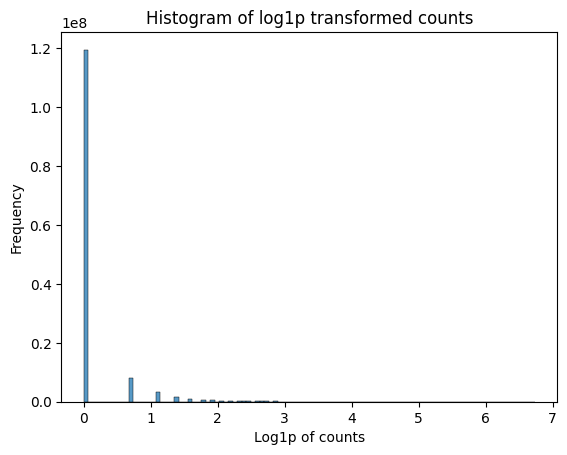

In [12]:
# 3. Quick histogram of the counts (log scale)
sns.histplot(np.log1p(X).ravel(), bins=100)
plt.xlabel('Log1p of counts')
plt.ylabel('Frequency')
plt.title('Histogram of log1p transformed counts')
plt.show()

#### Doublets removal
Cell metadata already contains a `doub.densitiy` score and `doublet` boolean columns:

In [13]:
print("Number of doublets:", (adata_sc.obs['doublet'] == True).sum())

Number of doublets: 751


In [14]:
adata_sc.obs['doub.density'].describe()

count    4651.000000
mean        0.581675
std         0.989827
min         0.000000
25%         0.054119
50%         0.272800
75%         0.656950
max        18.825038
Name: doub.density, dtype: float64

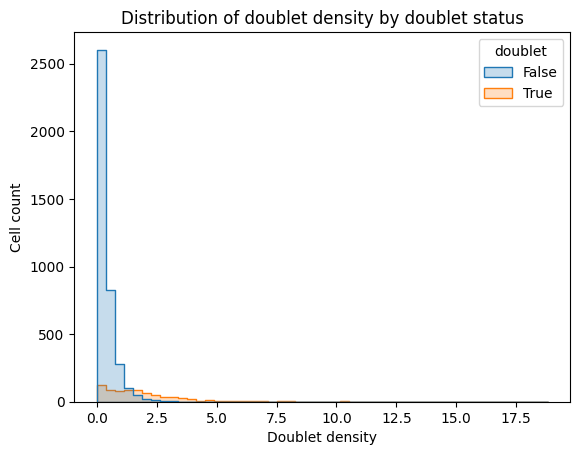

In [15]:
# Plot doublet density distribution by doublet status
sns.histplot(
    data=adata_sc.obs,
    x='doub.density',
    hue='doublet',
    bins=50,
    element='step',
    common_norm=False
)
plt.xlabel('Doublet density')
plt.ylabel('Cell count')
plt.title('Distribution of doublet density by doublet status')
plt.show()


In [16]:
adata_sc.obs.groupby('doublet')['doub.density'].describe()

,count,mean,std,min,25%,50%,75%,max
doublet,,,,,,,,
False,3900.0,0.333315,0.403295,0.0,0.033196,0.209771,0.481803,3.568961
True,751.0,1.871430,1.800696,0.0,0.627046,1.486389,2.555030,18.825038


In [42]:
# remove doublets
adata_sc = adata_sc[adata_sc.obs['doublet'] == False].copy()
adata_sc



AnnData object with n_obs × n_vars = 3900 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'X_name'

#### Emtpy cells filtering

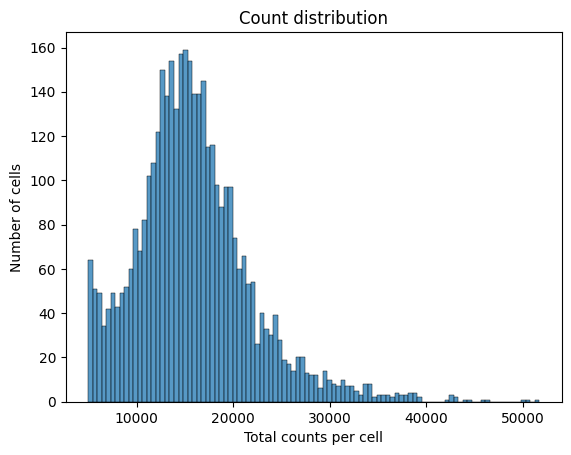

In [18]:
import seaborn as sns, matplotlib.pyplot as plt
adata_sc.obs['n_counts'] = np.array(adata_sc.X.sum(axis=1)).ravel()

sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.xlabel('Total counts per cell')
plt.ylabel('Number of cells')
plt.title('Count distribution')
plt.show()

In [19]:
low, high = np.percentile(adata_sc.obs['n_counts'], [2, 98])
print(low, high)


5656.78 31935.38


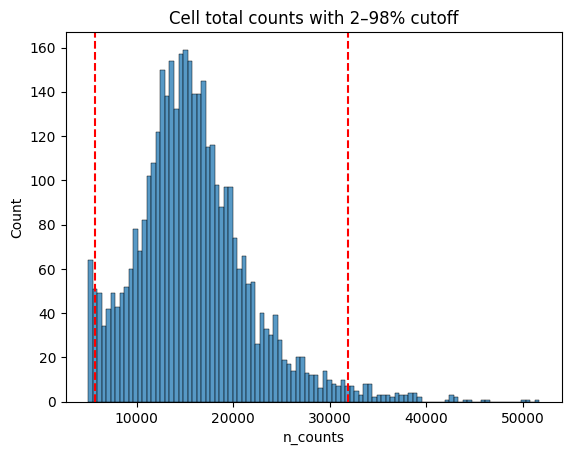

In [20]:
sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.axvline(low, color='red', linestyle='--')
plt.axvline(high, color='red', linestyle='--')
plt.title('Cell total counts with 2–98% cutoff')
plt.show()


Considering that doubltes are already absent, empty droplets are liekly to be as well, so we do not remove any cells.

In [10]:
print("Number of empty cells: ", ((adata_sc.X.sum(axis=1) == 0).sum()))

Number of empty cells:  0


#### Genes filtering

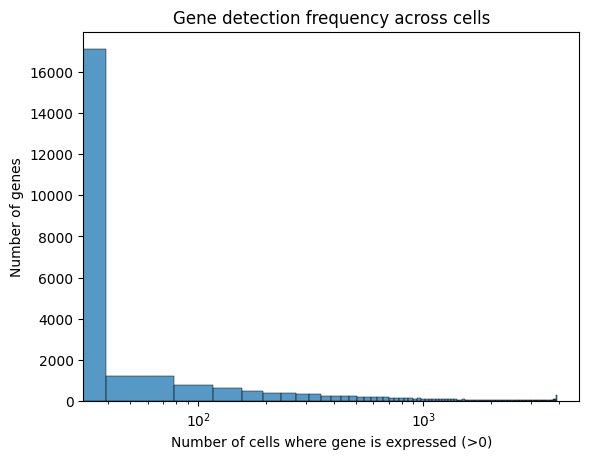

In [13]:
# compute counts if not already done
if 'n_cells_expressed' not in adata_sc.var.columns:
    adata_sc.var['n_cells_expressed'] = np.array((adata_sc.X > 0).sum(axis=0)).ravel()

# histogram (log scale on x is clearer)
sns.histplot(adata_sc.var['n_cells_expressed'], bins=100)
plt.xscale('log')
plt.xlabel('Number of cells where gene is expressed (>0)')
plt.ylabel('Number of genes')
plt.title('Gene detection frequency across cells')
plt.show()


In [22]:
print("Number of genes not expressed in any cell:", (adata_sc.var['n_cells_expressed'] == 0).sum())


Number of genes not expressed in any cell: 10701


<Axes: xlabel='n_cells_expressed', ylabel='Count'>

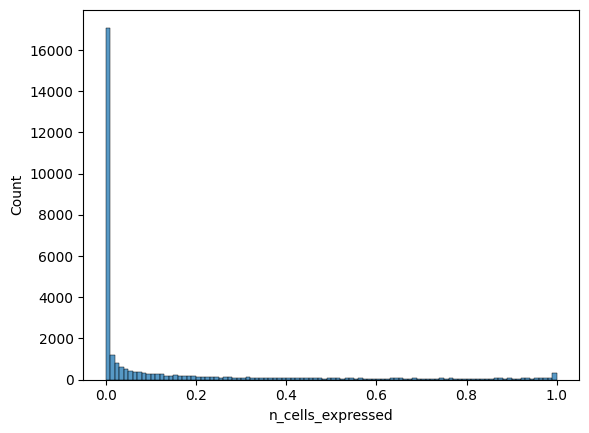

In [ ]:
# plot histogram of per-gene-sparsity
sns.histplot(adata_sc.var['n_cells_expressed'] / adata_sc.shape[0], bins=100)
plt.xlabel("sparsity")
plt.ylabel("number of genes")


In [37]:
low_genes = np.percentile(adata_sc.var['n_cells_expressed'], 40)
low_genes


np.float64(1.0)

9 cells is the median, 1 cell occurs at the $\approx$ 37 quantile ...

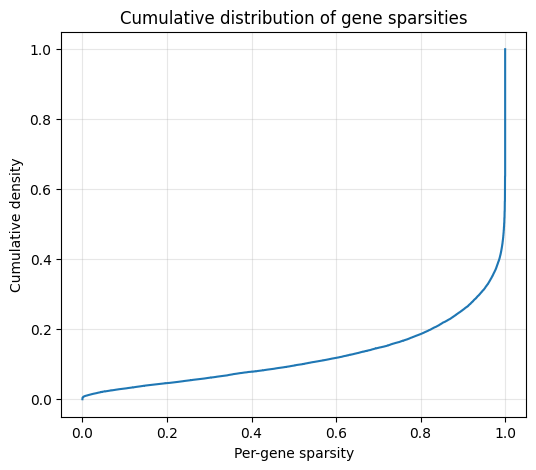

In [29]:
# per-gene frequency of expression
freq = adata_sc.var['n_cells_expressed'] / adata_sc.shape[0]

# sparsity = 1 - frequency
sparsity = 1 - freq

# sort and compute empirical CDF
sparsity_sorted = np.sort(sparsity)
cdf = np.arange(1, len(sparsity_sorted) + 1) / len(sparsity_sorted)

# build dataframe if needed
pdf = pd.DataFrame({'sparsity': sparsity_sorted, 'cdf': cdf})

# plot
plt.figure(figsize=(6,5))
plt.plot(pdf['sparsity'], pdf['cdf'])
plt.xlabel('Per-gene sparsity')
plt.ylabel('Cumulative density')
plt.title('Cumulative distribution of gene sparsities')
plt.grid(True, alpha=0.3)
plt.show()


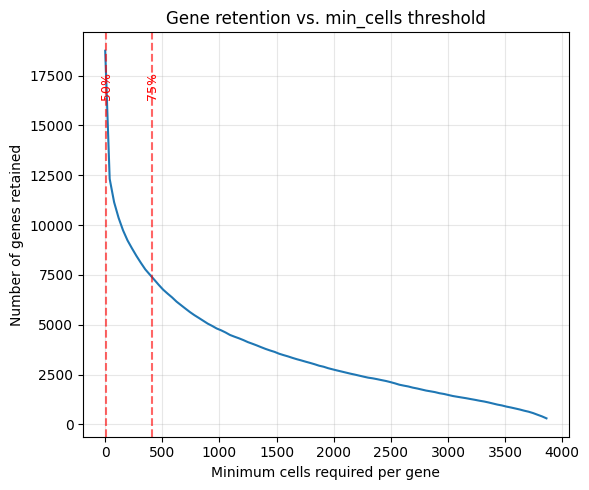

In [34]:
n_cells = adata_sc.shape[0]
n_cells_expr = adata_sc.var['n_cells_expressed'].to_numpy()

# thresholds for min_cells
thresholds = np.arange(1, n_cells + 1, int(n_cells / 100))
genes_kept = [(n_cells_expr >= t).sum() for t in thresholds]

# quantiles of gene expression counts
quantiles = np.quantile(n_cells_expr, [0.5, 0.75])

plt.figure(figsize=(6,5))
plt.plot(thresholds, genes_kept, label='Genes retained')
for q, label in zip(quantiles, ['50%', '75%']):
    plt.axvline(q, color='r', linestyle='--', alpha=0.6)
    plt.text(q, plt.ylim()[1]*0.9, label, rotation=90, color='r',
             ha='center', va='top', fontsize=9)

plt.xlabel('Minimum cells required per gene')
plt.ylabel('Number of genes retained')
plt.title('Gene retention vs. min_cells threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




In [43]:
# keep genes expressed in at least one cell
sc.pp.filter_genes(adata_sc, min_cells=4)
adata_sc


/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3900 × 16169
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells'
    uns: 'X_name'

#### Normalization

In [44]:
# log-normalize
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
adata_sc

AnnData object with n_obs × n_vars = 3900 × 16169
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells'
    uns: 'X_name', 'log1p'

In [45]:
np.min(adata_sc.X), np.max(adata_sc.X)

(np.float64(0.0), np.float64(6.670955150204661))

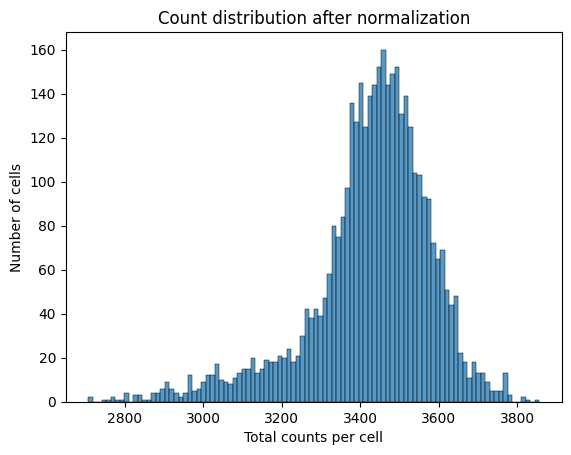

In [46]:
# plot n_counts after normalization
adata_sc.obs['n_counts'] = np.array(adata_sc.X.sum(axis=1)).ravel()

sns.histplot(adata_sc.obs['n_counts'], bins=100)
plt.xlabel('Total counts per cell')
plt.ylabel('Number of cells')
plt.title('Count distribution after normalization')
plt.show()

#### Sparsity

In [47]:
## add sparsity in uns
# handle sparse or dense automatically
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_sc.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_sc.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.7776


#### HVGs

In [48]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=2000,
    flavor='seurat_v3'
)
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 3900 × 16169
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'n_counts'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'log1p', 'sparsity', 'hvg'

#### Save

In [49]:
sc.write(adata=adata_sc, filename=data_path + "scRNA_data.h5ad")

## seqFISH data

#### Data reading

ST data of seqFISH experiment on Mouse Gastrulation tissue with ID, spatial coordinates, metadata including cell type annotation.

In [36]:
adata_st = sc.read(data_path + "seqFISH_data_full.h5ad")  # .obsm['spatial'] contains affine coordinates
adata_st

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

The coordinates saved in `adata_st.obsm['spatial']` are obtained as `adata_st.obs[['x_global_affine', 'y_global_affine']].to_numpy()`.

#### Spatial visualization

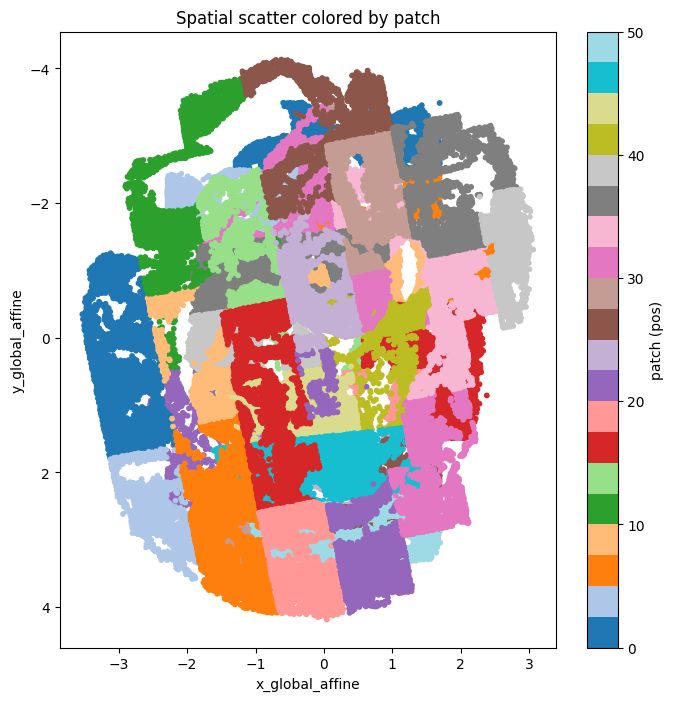

In [37]:
# x and y coordinates (affine)
import matplotlib.pyplot as plt
x = adata_st.obs['x_global_affine']
y = adata_st.obs['y_global_affine']

# color by spot (pos)
colors = adata_st.obs['pos']

plt.figure(figsize=(8,8))
scatter = plt.scatter(x, y, c=colors.astype('category').cat.codes, cmap='tab20', s=10)
plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title('Spatial scatter colored by patch')
plt.gca().invert_yaxis()  # optional, for typical tissue orientation
plt.colorbar(scatter, label='patch (pos)')
plt.show()

#### Spots sub-sampling
In the benchmarking paper the total number of spots is $8425$, despite the full seqFISH data having $57535$ spots.
The subsampling pattern, based on the comparison of the first 4 spatial coordinates in `Locations.txt`, seems to be that the $i$-th spot in the subset corresponds to the $2i+1$-th spot in the original set, but the pattern brakes in the last 4 values at least.

We also check whether the subset sub-sampling is related to spatial information, such as the position in the sample:

In [38]:
adata_st.obs['pos'].unique()

['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', ..., 'Pos46', 'Pos47', 'Pos48', 'Pos49', 'Pos50']
Length: 51
Categories (51, object): ['Pos0', 'Pos1', 'Pos2', 'Pos3', ..., 'Pos47', 'Pos48', 'Pos49', 'Pos50']

/tmp/ipykernel_123629/1888836743.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x, y, cmap='tab20', s=10)


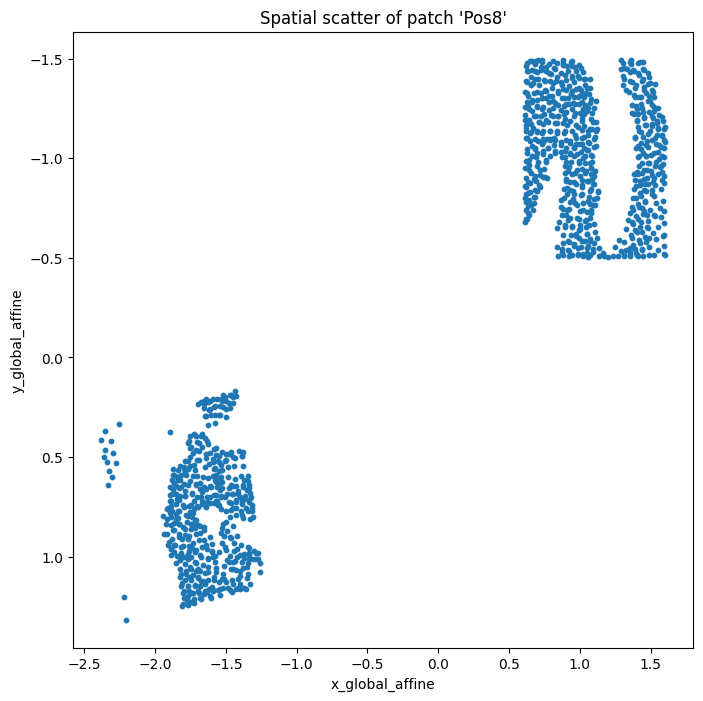

In [57]:
# x and y coordinates (affine)
pos = '8'
x = adata_st[adata_st.obs['pos'] == f'Pos{pos}'].obs['x_global_affine']
y = adata_st[adata_st.obs['pos'] == f'Pos{pos}'].obs['y_global_affine']


plt.figure(figsize=(8,8))
scatter = plt.scatter(x, y, cmap='tab20', s=10)
plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title(f'Spatial scatter of patch \'Pos{pos}\'')
plt.gca().invert_yaxis()  # optional, for typical tissue orientation
plt.show()

In [53]:
# Check #spots per position and cumulative sum
cum_sum = 0
for pos_num in np.linspace(0,adata_st.obs['pos'].nunique()-1,adata_st.obs['pos'].nunique(), dtype='int'):
    len = adata_st.obs.loc[adata_st.obs['pos'] == f'Pos{pos_num}'].shape[0]
    cum_sum += len
    print(f"Pos{pos_num}: {len}, cumulative sum = {cum_sum}")

Pos0: 1301, cumulative sum = 1301
Pos1: 1416, cumulative sum = 2717
Pos2: 1324, cumulative sum = 4041
Pos3: 1399, cumulative sum = 5440
Pos4: 1204, cumulative sum = 6644
Pos5: 1526, cumulative sum = 8170
Pos6: 1683, cumulative sum = 9853
Pos7: 1317, cumulative sum = 11170
Pos8: 1172, cumulative sum = 12342
Pos9: 1081, cumulative sum = 13423
Pos10: 1354, cumulative sum = 14777
Pos11: 906, cumulative sum = 15683
Pos12: 941, cumulative sum = 16624
Pos13: 1021, cumulative sum = 17645
Pos14: 760, cumulative sum = 18405
Pos15: 1682, cumulative sum = 20087
Pos16: 1300, cumulative sum = 21387
Pos17: 1481, cumulative sum = 22868
Pos18: 1308, cumulative sum = 24176
Pos19: 996, cumulative sum = 25172
Pos20: 1531, cumulative sum = 26703
Pos21: 920, cumulative sum = 27623
Pos22: 615, cumulative sum = 28238
Pos23: 1391, cumulative sum = 29629
Pos24: 711, cumulative sum = 30340
Pos25: 1435, cumulative sum = 31775
Pos26: 1148, cumulative sum = 32923
Pos27: 1678, cumulative sum = 34601
Pos28: 1444, cum

Since we cannot replicate the paper strategy, we alternatively select a random subset of n genes per 'pos', where n is n_scrna_obs // n_pos to match as closely the number of obs in scrna data (no filtering necessay in Tangram), while also having an unbiased sample that covers all tissue:

In [54]:
num_spots_per_pos = adata_sc.obs.shape[0] // adata_st.obs['pos'].nunique()
print(num_spots_per_pos)

76


In [55]:
# Ensure reproducibility
np.random.seed(42)

# Grouped sampling: 78 obs per 'pos' level
sampled_idx = (
    adata_st.obs.groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(n=num_spots_per_pos, replace=False))
    .index
)

# Subset the AnnData
adata_st_subsampled = adata_st[sampled_idx].copy()

# The copy inherits obs, var, uns, layers, and obsm
adata_st_subsampled


/tmp/ipykernel_123629/4021742334.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_st.obs.groupby('pos', group_keys=False)
/tmp/ipykernel_123629/4021742334.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=num_spots_per_pos, replace=False))


AnnData object with n_obs × n_vars = 3876 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

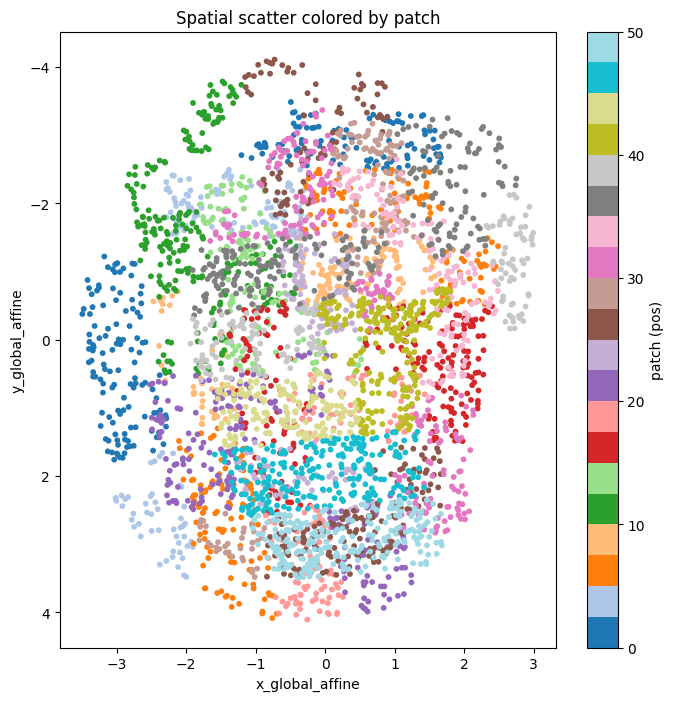

In [56]:
x = adata_st_subsampled.obs['x_global_affine']
y = adata_st_subsampled.obs['y_global_affine']

# color by spot (pos)
colors = adata_st_subsampled.obs['pos']

plt.figure(figsize=(8,8))
scatter = plt.scatter(x, y, c=colors.astype('category').cat.codes, cmap='tab20', s=10)
plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title('Spatial scatter colored by patch')
plt.gca().invert_yaxis()  # optional, for typical tissue orientation
plt.colorbar(scatter, label='patch (pos)')
plt.show()

#### Count format inspection


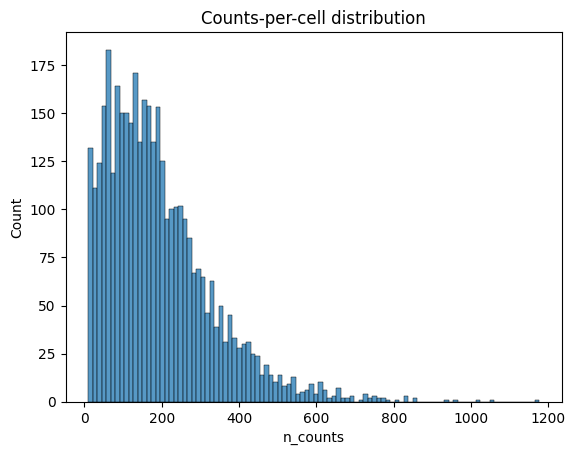

In [59]:
adata_st_subsampled.obs['n_counts'] = np.array(adata_st_subsampled.X.sum(axis=1)).ravel()

sns.histplot(adata_st_subsampled.obs['n_counts'], bins=100)
plt.title("Counts-per-cell distribution")
plt.show()

In [60]:
X = adata_st_subsampled.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

print("min:", X.min(), "max:", X.max(), "mean:", X.mean())

min: 0.0 max: 104.0 mean: 0.5489306683837127


In [61]:
adata_st.layers['logcounts']

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 5278996 stored elements and shape (57536, 351)>

Text(0, 0.5, 'Count')

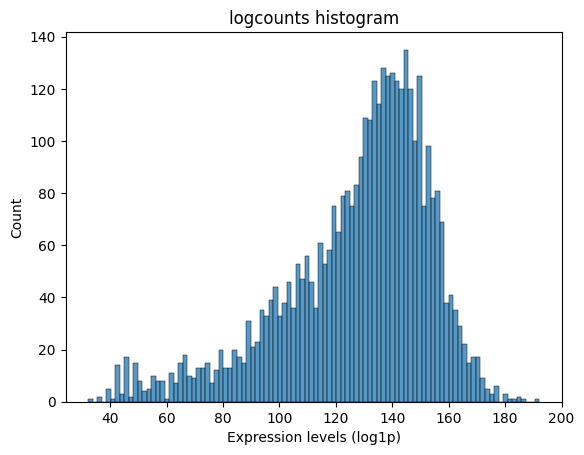

In [62]:
# extract logcounts and plt histogram
log_counts= np.array(adata_st_subsampled.layers['logcounts'].sum(axis=1)).ravel()

sns.histplot(log_counts, bins=100)
plt.title('logcounts histogram')
plt.xlabel('Expression levels (log1p)')
plt.ylabel('Count')

In [63]:
adata_st_subsampled.X = adata_st_subsampled.layers["logcounts"].copy()


#### Empty cells

In [52]:
print("numebr of empty cells = ", (adata_st.X.sum(axis=1) == 0).sum())

numebr of empty cells =  0


#### Undetected genes

In [53]:
print("numebr undetected genes = ", (adata_st.X.sum(axis=1) == 0).sum())

numebr undetected genes =  0


#### Sparsity

In [64]:
X = adata_st_subsampled.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_st_subsampled.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_st_subsampled.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.7389


#### Spatial graph
n_neigh=6 by default

In [65]:
import squidpy as sq
sq.gr.spatial_neighbors(
    adata_st_subsampled,
    coord_type='generic',   # 'visium' for Visium, 'generic' for single-cell resolution
    n_neighs=6,   
    set_diag=False,           # or adjust based on local cell density
    key_added="spatial"
)

In [66]:
adata_st_subsampled

AnnData object with n_obs × n_vars = 3876 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts'
    var: 'gene_id'
    uns: '.colData', 'X_name', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'logcounts'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### SA statistics
Computed on connectivities , not adjacencies.

In [67]:
# Moran’s I
sq.gr.spatial_autocorr(
    adata_st_subsampled,
    connectivity_key="spatial_connectivities",
    mode="moran",
    transformation=True,
    show_progress_bar=True,
)

# Geary’s C
sq.gr.spatial_autocorr(
    adata_st_subsampled,
    connectivity_key="spatial_connectivities",
    mode="geary",
    transformation=True,
    show_progress_bar=True,
)


In [68]:
adata_st_subsampled

AnnData object with n_obs × n_vars = 3876 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts'
    var: 'gene_id'
    uns: '.colData', 'X_name', 'sparsity', 'spatial_neighbors', 'moranI', 'gearyC'
    obsm: 'spatial'
    layers: 'logcounts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [72]:
adata_st_subsampled.uns['.colData']

{'segmentation_vertices_x_global_affine': {'embryo1_Pos0_cell100_z2': array([0.95969568, 0.96750818, 0.96750818, 0.9694613 , 0.97141443,
         0.98899255, 0.98899255, 0.99094568, 0.98703943, 0.98703943,
         0.9850863 , 0.98313318, 0.9772738 , 0.9772738 , 0.97532068,
         0.97532068, 0.97141443, 0.97141443, 0.96555505, 0.96360193,
         0.95578943, 0.9538363 , 0.94993005, 0.94993005, 0.94797693,
         0.94797693, 0.9460238 , 0.9460238 , 0.93625818, 0.93625818,
         0.93430505, 0.93430505, 0.94016443, 0.94016443, 0.94211755,
         0.94407068, 0.94797693, 0.95578943, 0.95578943, 0.95774255,
         0.95774255, 0.95969568]),
  'embryo1_Pos0_cell100_z5': array([0.97922693, 0.98118005, 0.98313318, 0.98703943, 0.98899255,
         0.98899255, 0.9928988 , 0.9928988 , 0.99680505, 0.99680505,
         0.99875818, 0.99875818, 1.0007113 , 1.0007113 , 1.00266443,
         1.00266443, 0.95969568, 0.95774255, 0.95774255, 0.95578943,
         0.95578943, 0.9538363 , 0.9538363

In this unstructured field the segmentation polygons vertices are stored, we remove it to make the data lighter:

In [74]:
del adata_st_subsampled.uns['.colData']
adata_st_subsampled

AnnData object with n_obs × n_vars = 3876 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts'
    var: 'gene_id'
    uns: 'X_name', 'sparsity', 'spatial_neighbors', 'moranI', 'gearyC'
    obsm: 'spatial'
    layers: 'logcounts'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### Save

In [75]:
# save
sc.write(filename=data_path + "seqFISH_data.h5ad", adata=adata_st_subsampled, ext='h5ad')

# Data Loading

In [76]:
adata_sc = sc.read(data_path + "scRNA_data.h5ad") 
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3900 × 18751
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'n_counts'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'hvg', 'log1p', 'sparsity'

In [5]:
adata_st = sc.read(data_path + "spatial_data.h5ad")
adata_st

AnnData object with n_obs × n_vars = 3876 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts'
    var: 'gene_id'
    uns: 'X_name', 'gearyC', 'moranI', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'logcounts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [8]:
adata_st.obs['celltype_mapped_refined'].unique()

['Lateral plate mesoderm', 'Erythroid', 'Gut tube', 'Low quality', 'Endothelium', ..., 'Presomitic mesoderm', 'NMP', 'Cardiomyocytes', 'ExE endoderm', 'Blood progenitors']
Length: 24
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']

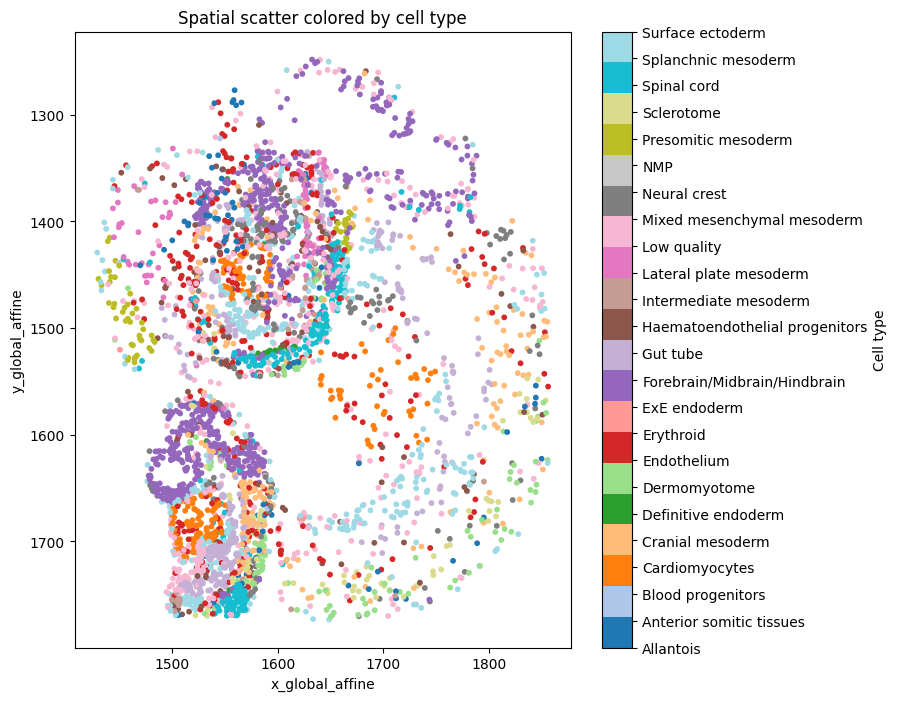

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

x = adata_st.obs['x_global']
y = adata_st.obs['y_global']

celltypes = adata_st.obs['celltype_mapped_refined'].astype('category')
codes = celltypes.cat.codes

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    x, y,
    c=codes,
    cmap='tab20',
    s=10
)

plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title('Spatial scatter colored by cell type')
plt.gca().invert_yaxis()

cbar = plt.colorbar(scatter, ticks=range(len(celltypes.cat.categories)))
cbar.ax.set_yticklabels(celltypes.cat.categories)
cbar.set_label('Cell type')

plt.show()


## Harmonization

In [94]:
# Check cell types overlap
print("scRNA cell types: \n", adata_sc.obs['celltype'].unique())
print("Spatial data cell types: \n", adata_st.obs['celltype_mapped_refined'].unique())
common_cts = list(set(adata_sc.obs['celltype'].unique()) & set(adata_st.obs['celltype_mapped_refined'].unique()))
print("Common cell types: \n", common_cts)
print(f"Length: {len(common_cts)}")

scRNA cell types: 
 ['Blood progenitors 2', 'ExE ectoderm', 'Epiblast', 'Rostral neurectoderm', 'Haematoendothelial progenitors', ..., 'Visceral endoderm', 'Surface ectoderm', 'Intermediate mesoderm', 'Somitic mesoderm', 'Allantois']
Length: 29
Categories (28, object): ['Allantois', 'Anterior Primitive Streak', 'Blood progenitors 1', 'Blood progenitors 2', ..., 'Rostral neurectoderm', 'Somitic mesoderm', 'Surface ectoderm', 'Visceral endoderm']
Spatial data cell types: 
 ['Lateral plate mesoderm', 'Erythroid', 'Gut tube', 'Low quality', 'Endothelium', ..., 'Presomitic mesoderm', 'NMP', 'Cardiomyocytes', 'ExE endoderm', 'Blood progenitors']
Length: 24
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']
Common cell types: 
 ['Intermediate mesoderm', 'Haematoendothelial progenitors', 'Surface ectoderm', 'ExE endoderm', 'Allantois']
Length: 5


In [95]:
adata_sc = adata_sc[adata_sc.obs['celltype'].isin(common_cts)]
adata_st = adata_st[adata_st.obs['celltype_mapped_refined'].isin(common_cts)]

print(adata_sc.shape)
print(adata_st.shape)

(404, 18751)
(416, 351)


Cardinality drops miserably but is still in 1-to-1 proportion:

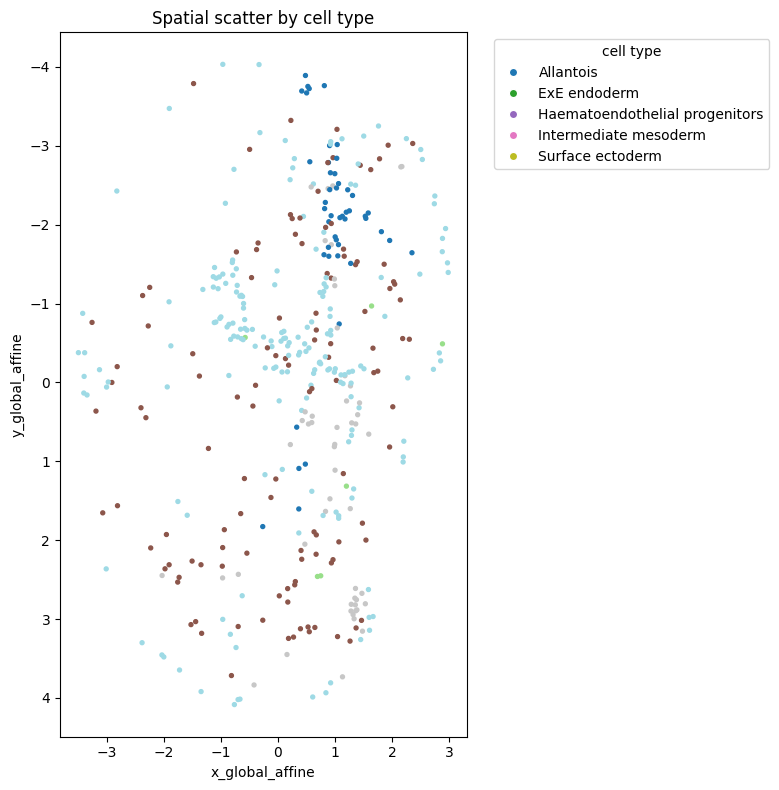

In [96]:
x = adata_st.obs['x_global_affine']
y = adata_st.obs['y_global_affine']
labels = adata_st.obs['celltype_mapped_refined'].astype('category')
codes = labels.cat.codes
categories = labels.cat.categories

plt.figure(figsize=(8,8))
sc = plt.scatter(x, y, c=codes, cmap='tab20', s=8)
plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title('Spatial scatter by cell type')
plt.gca().invert_yaxis()

# legend mapping colors to categories
handles = [plt.Line2D([], [], marker='o', color='w', label=cat,
                      markerfacecolor=plt.cm.tab20(i / len(categories)), markersize=6)
           for i, cat in enumerate(categories)]
plt.legend(handles=handles, title='cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()